#Import libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


# Load your data

In [30]:
df = pd.read_csv("customer_support_tickets.csv")

# Drop rows with missing description or type

In [31]:
df = df.dropna(subset=['Ticket Type', 'Ticket Description'])

# Encode target labels

In [32]:
le = LabelEncoder()
df['Ticket Type Encoded'] = le.fit_transform(df['Ticket Type'])

# Features and target

In [33]:
X = df['Ticket Description']
y = df['Ticket Type Encoded']


# Train/Test split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# -----------------------
# Logistic Regression
# -----------------------

In [35]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid_lr = {
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['liblinear']
}

grid_lr = GridSearchCV(pipeline_lr, param_grid=param_grid_lr, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10], 'clf__penalty': ['l2'],
                         'clf__solver': ['liblinear']},
             scoring='f1_weighted')

In [36]:
# -----------------------
# Random Forest
# -----------------------

In [37]:
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

param_dist_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

rand_rf = RandomizedSearchCV(pipeline_rf, param_distributions=param_dist_rf, n_iter=5, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42)
rand_rf.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'clf__max_depth': [None, 10, 20],
                                        'clf__min_samples_split': [2, 5],
                                        'clf__n_estimators': [50, 100]},
                   random_state=42, scoring='f1_weighted')

# -----------------------
# Evaluation
# -----------------------

In [38]:
def evaluate(model, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

evaluate(grid_lr, "Logistic Regression (GridSearchCV)")
evaluate(rand_rf, "Random Forest (RandomizedSearchCV)")


Logistic Regression (GridSearchCV) Evaluation:
Accuracy: 0.19244391971664698
Precision: 0.18975183563204578
Recall: 0.19244391971664698
F1-Score: 0.19002790165140035

Classification Report:
                       precision    recall  f1-score   support

     Billing inquiry       0.16      0.11      0.13       357
Cancellation request       0.18      0.19      0.18       327
     Product inquiry       0.19      0.19      0.19       316
      Refund request       0.20      0.23      0.22       345
     Technical issue       0.22      0.24      0.23       349

            accuracy                           0.19      1694
           macro avg       0.19      0.19      0.19      1694
        weighted avg       0.19      0.19      0.19      1694


Random Forest (RandomizedSearchCV) Evaluation:
Accuracy: 0.21369539551357733
Precision: 0.2135286911326899
Recall: 0.21369539551357733
F1-Score: 0.21313078727955773

Classification Report:
                       precision    recall  f1-score   su

# -----------------------
# 📊 Confusion Matrix
# -----------------------

In [47]:
# Load the data
df = pd.read_csv("customer_support_tickets.csv")
df = df.dropna(subset=['Ticket Type', 'Ticket Description'])

# Encode target
le = LabelEncoder()
df['Ticket Type Encoded'] = le.fit_transform(df['Ticket Type'])

# Split
X = df['Ticket Description']
y = df['Ticket Type Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


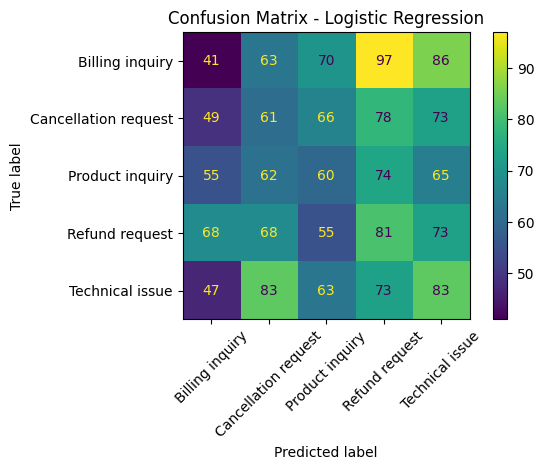

In [48]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=1000))
])

pipeline_lr.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    pipeline_lr, X_test, y_test, display_labels=le.classes_, xticks_rotation=45
)
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()


In [39]:
# Use the TF-IDF vectorizer from the trained pipeline (you can use rand_rf or grid_lr)
tfidf_vect = rand_rf.best_estimator_.named_steps['tfidf']

# Transform training data to get the TF-IDF matrix
tfidf_matrix = tfidf_vect.transform(X_train)

# Get feature names and average TF-IDF scores
feature_names = tfidf_vect.get_feature_names_out()
avg_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).ravel()

# Get top N words
N = 20
top_indices = np.argsort(avg_tfidf)[-N:]
top_features = [feature_names[i] for i in top_indices]
top_scores = avg_tfidf[top_indices]

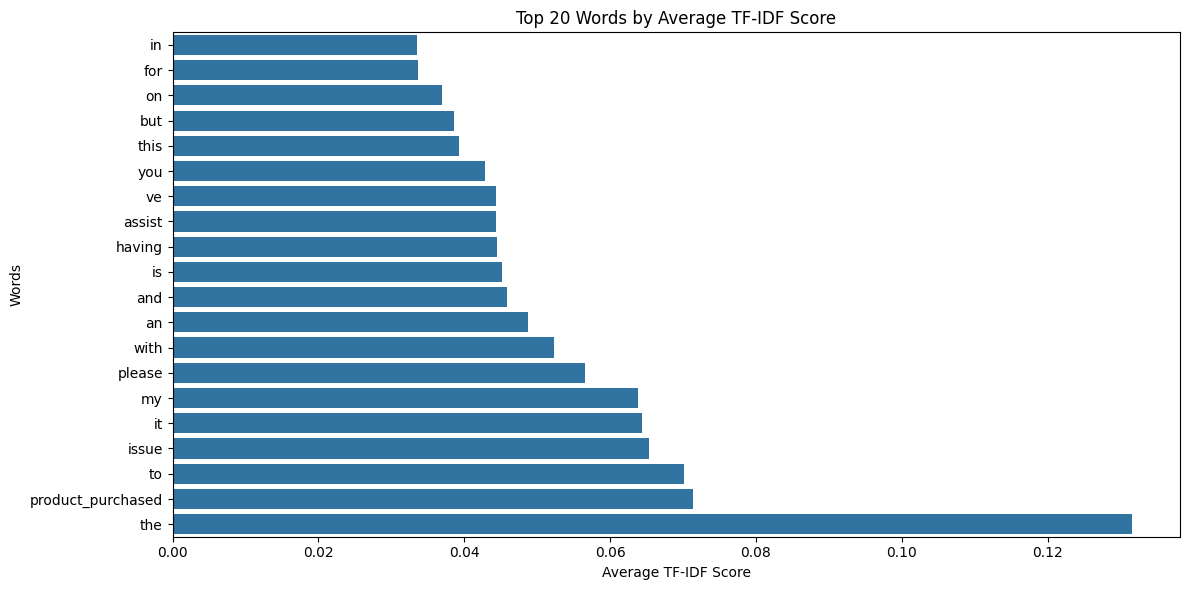

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_scores, y=top_features)
plt.title("Top 20 Words by Average TF-IDF Score")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

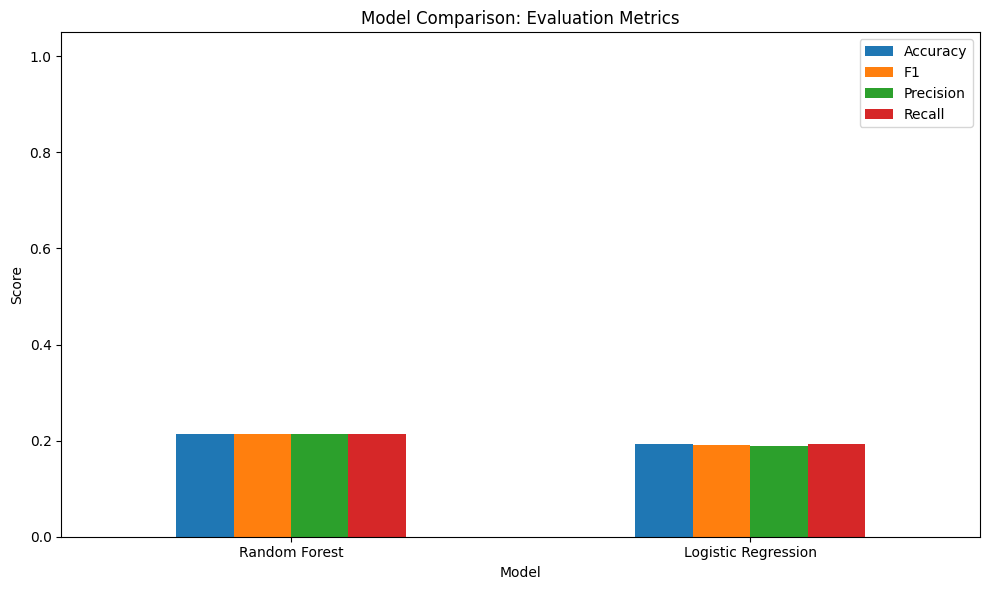

In [44]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def model_scores(model, name):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    }

scores_df = pd.DataFrame([
    model_scores(rand_rf, 'Random Forest'),
    model_scores(pipeline_lr, 'Logistic Regression')
])

scores_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison: Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


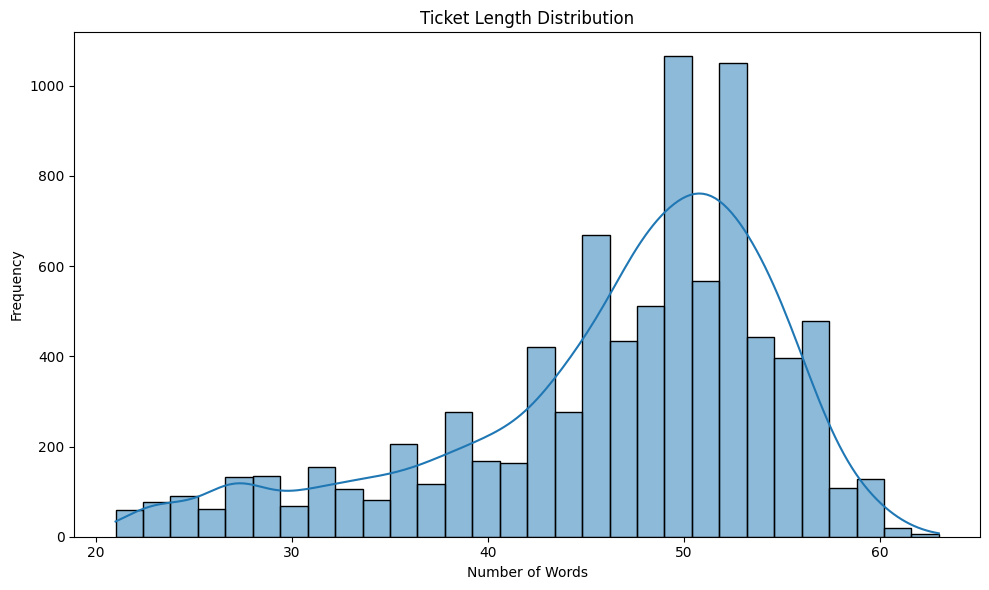

In [45]:
df['ticket_length'] = df['Ticket Description'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['ticket_length'], bins=30, kde=True)
plt.title("Ticket Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# -----------------------
# User Input Prediction
# -----------------------


In [49]:
def predict_ticket_type(description, model, label_encoder):
    pred = model.predict([description])
    return label_encoder.inverse_transform(pred)[0]

# Example: Get input from the user
user_input = input("\nEnter your support query: ")

# Predict using both models
pred_lr = predict_ticket_type(user_input, grid_lr.best_estimator_, le)
pred_rf = predict_ticket_type(user_input, rand_rf.best_estimator_, le)

print("\n Predicted Ticket Type:")
print(f"Logistic Regression Prediction: {pred_lr}")
print(f"Random Forest Prediction: {pred_rf}")


Enter your support query: i am not getting my refund

 Predicted Ticket Type:
Logistic Regression Prediction: Billing inquiry
Random Forest Prediction: Refund request
